# Symbolic Music Alignment

Automatic Music Alignment refers to the task of linking or matching two musical signals of the same musical work. This can be, e.g., matching *different performances* of the same piece, or matching the performance of a piece with its musical score.

The following figure shows a common music alignment pipeline:

<img src="figures/alignment_pipeline.png" alt="alignment_pipeline" width="600"/>

In this part of the tutorial we are going to explore these components in more detail.

## Music Representation

Music representations, since this is a tutorial on symbolic music processing, we will focus on symbolic music representations, such that can be stored in formats such as MIDI, MusicXML or MEI, and that can be generated by editors like MuseScore, Finale, etc.

### Audio vs. Symbolic Alignment

* In **Audio-to-audio alignment**, the alignment itself typically refers to  of *timestamps* (in absolute time in seconds) in one audio recording of a musical work to the corresponding *timestamp* in another recording. (In audio recordings, identifying individual notes is [not a trivial task!](ADD_LINK_TO_REFERENCES))

* In **Symbolic-to-symbolic alignment**, we can have two types of alignment:
    * **Time-wise alignments**: similar to audio-based alignment, we can map timestamps (in symbolic time units like musical beats or MIDI ticks) from one version of the work to another (e.g., a MIDI performance to a score in MusicXML/MEI/Humdrum format). 
    * **Note-wise alignment**: We can map individual symbolic music elements (most commonly notes) from one version to another. This is very useful for modeling expressive performance.


### Types of music alignment

We can categorize musical alignment in two main dimensions: (representation) modality and time.

#### Representation modality


* **Audio-to-audio alignment**: Alignment of two (audio) recordings. This is probably the most studied type of alignment in the MIR literature.
* **Symbolic-to-audio alignment**: Alignment of symbolically encoded score events with timestamps positions in a recording.
* **Image-to-audio alignment**: Alignment of spatial positions (e.g., bounding boxes of musical measures given in pixels) of digitized images of sheet music with time positions of a recording.
* **Lyrics-to-audio alignment**: Alignment of lyrics (given in text format) with time positions of a recorded song.

#### Time

* **Offline**: Alignment of two *recordings/documents* (i.e., audio recordings, MIDI performances, MusicXML scores, etc.). These recordings/documents can be in any of the modalities described above, the important thing being that the music is occurring in real-time.

* **Online**: Alignment of a live (i.e., real time) performance to the music encoded in a target document (e.g., a pre-annotated audio recording, a symbolic score, etc.). The problem of real time online alignment is known in the MIR literature a **score following**, and can be useful in live interactive settings, such as automatic accompaniment systems

In this tutorial we are going to focus on the case of offline alignment (but there will be a real-time demo at the end 😉).

## Feature Representations

To make musical data comparable for alignment algorithms, the first step is to extract features that capture relevant aspects while suppressing irrelevant details.

Let's make a quick mathematical parenthesis. For algorithmic purposes, it is convenient to represent the music captured by whichever music representation that we working with as *sequences of features*. 

Let us consider two sequences $\mathbf{X} = \{\mathbf{x}_1, \dots \mathbf{x}_N\}$ and $\mathbf{Y} = \{\mathbf{y}_1, \dots, \mathbf{y}_M\}$ for which we want to find an aligment.

* This sequences could be discrete signals, feature sequences, sequences of characters, etc.

* The elements $\mathbf{x}_n$, $\mathbf{y}_m$ belong to the same **feature space** $\mathcal{F}$. For the purposes of this tutorial, let us consider these elements as $K$-dimensional real-vectors, i.e., $\mathbf{x}, \mathbf{y} \in \mathbb{R}^K$ although they can other kind of objects (e.g., characters in an alphabet).

An important aspect of this feature space is that it allows us to use *quantitive measures* of how similar the elements of sequence $\mathbf{X}$ are to the elements in sequence $\mathbf{Y}$. We will come back to this point in a moment.

In this tutorial we are going to focus on 2 common features representations:

1. Piano Rolls
2. Pitch Class Distributions

### Piano Rolls

A piano roll is a 2D representation of (MIDI) pitch and time. We can extract piano rolls from symbolic music files with Partitura!

In [1]:
# Let's start by importing some stuff
import os
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import matplotlib.pyplot as plt
import partitura as pt

from helper import (
    compute_pitch_class_pianoroll, 
    generate_example_sequences, 
    plot_alignment
)

from typing import List

%config InlineBackend.figure_format ='retina'

In [2]:
# Let's load a score and a performance of the score
score_fn = "data/mozart_k265_var1.musicxml"
performance_fn = "data/mozart_k265_var1.mid"

score = pt.load_score(score_fn)
performance = pt.load_performance(performance_fn)

In [3]:
# Compute piano roll
use_piano_range = False
score_pr = pt.utils.music.compute_pianoroll(
    note_info=score,
    # time_unit="auto"
    # time_div="auto",
    # onset_only=False,
    # note_separation=False,
    # remove_silence=True,
    piano_range=use_piano_range,
    # return_idxs=False,
)

performance_pr = pt.utils.music.compute_pianoroll(
    note_info=performance,
    # time_unit="auto"
    # time_div="auto",
    # onset_only=False,
    # note_separation=False,
    # remove_silence=True,
    piano_range=use_piano_range,
    # return_idxs=False,  
)

Let's have a look at the output of these functions:

In [4]:
score_pr

<128x384 sparse matrix of type '<class 'numpy.int64'>'
	with 782 stored elements in Compressed Sparse Column format>

By default, piano rolls computed with partitura are stored in scipy's sparse matrices, since most of the elements are 0.

The first dimension of the array is MIDI pitch (128) and the second dimension are discrete time-steps defined by the `time_div` and `time_unit` arguments of the  `compute_pianoroll` function.

Let's visualize the piano rolls!

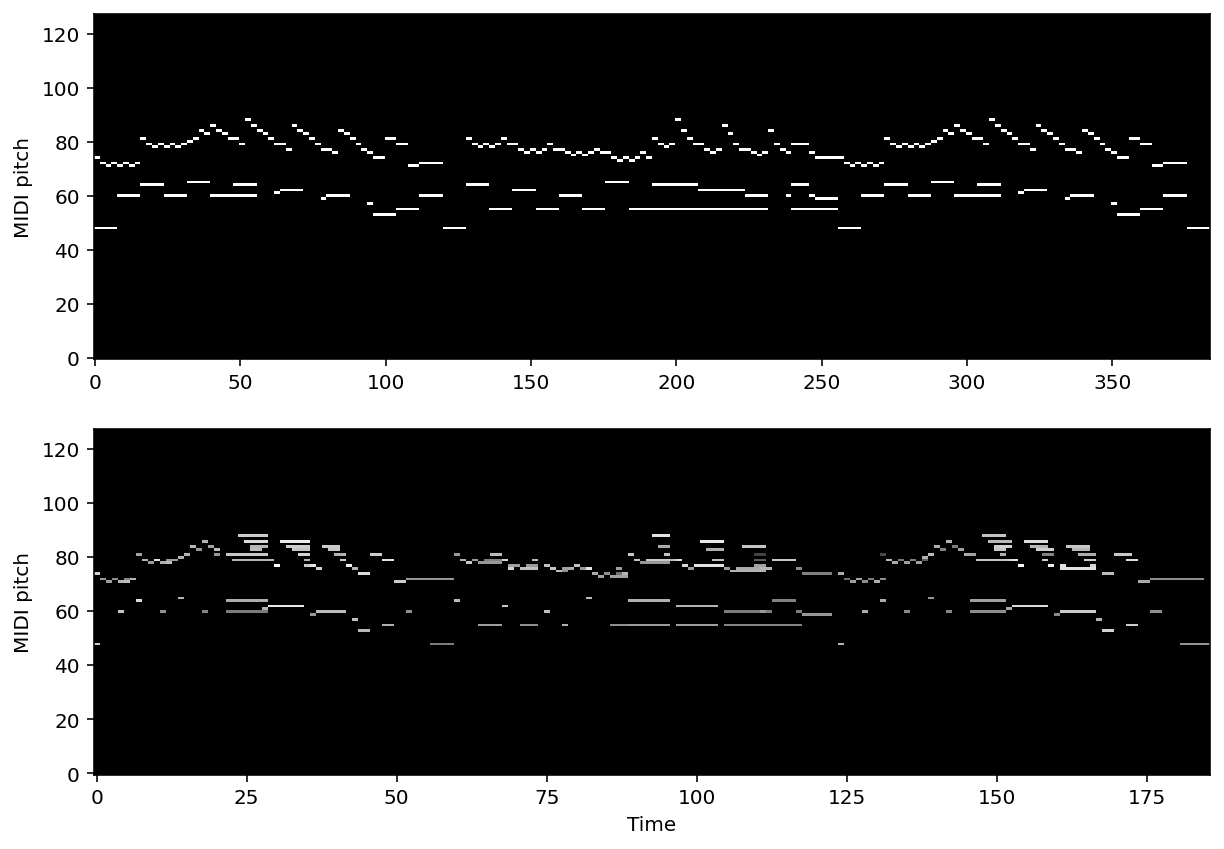

In [5]:
%matplotlib inline

fig, axes = plt.subplots(2, figsize=(10, 7))
axes[0].imshow(
    score_pr.todense(), 
    aspect = "auto", 
    origin="lower", 
    cmap="gray",
    interpolation="nearest",
)
axes[1].imshow(
    performance_pr.todense(), 
    aspect = "auto", 
    origin="lower", 
    cmap="gray",
    interpolation="nearest",
)
y_label = "Piano key" if use_piano_range else "MIDI pitch"
axes[0].set_ylabel(y_label)
axes[1].set_ylabel(y_label)
axes[1].set_xlabel("Time")
plt.show()

For more information, see the documentation of  [`compute_pianoroll`](https://partitura.readthedocs.io/en/latest/modules/partitura.utils.html#partitura.utils.compute_pianoroll).

### Pitch Class Distributions

These features are the symbolic equivalent to *chroma* features in audio. This representation is basically a piano roll that has been folded into a single octave.

In [27]:
score_pc_pr = compute_pitch_class_pianoroll(
    score,
    normalize=True,
    time_unit="beat",
    time_div=4
)

Let's plot this feature and compare it to a piano roll of the same score!

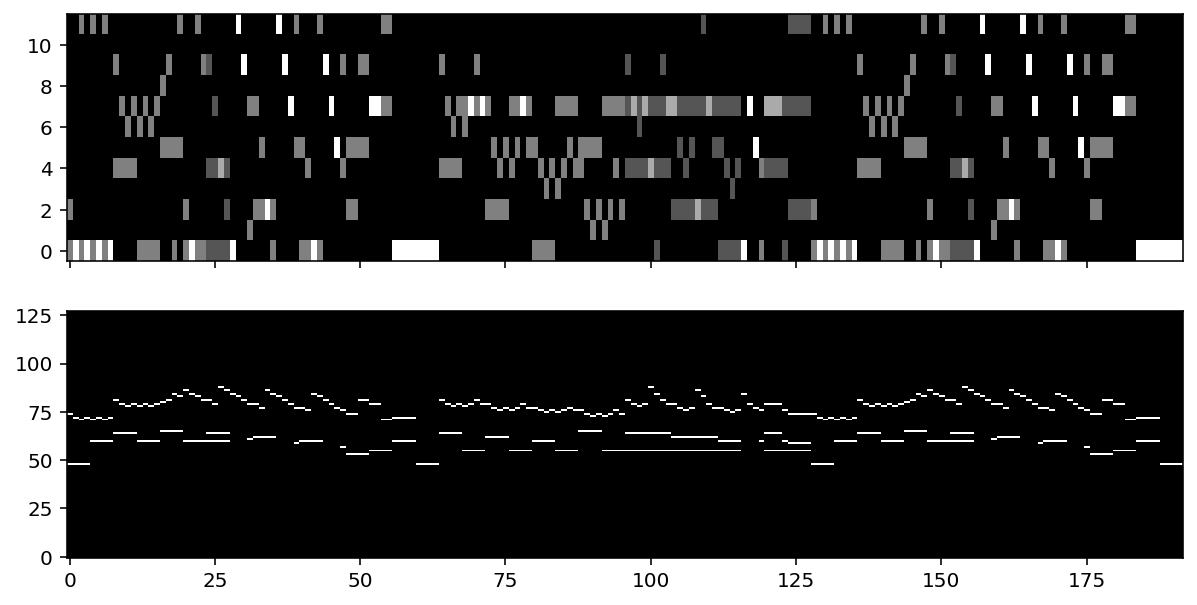

In [28]:
score_pr = pt.utils.music.compute_pianoroll(
    note_info=score,
    time_unit="beat",
    time_div=4,
    piano_range=False
)

fig, axes = plt.subplots(2, figsize=(10, 5), sharex=True)

axes[0].imshow(score_pc_pr, aspect = "auto", 
    origin="lower", 
    cmap="gray",
    interpolation="nearest",)
axes[1].imshow(score_pr.todense(), aspect="auto", origin="lower", cmap="gray", interpolation="nearest")

plt.show()

## Alignment Methods

We move now to methods for computing the alignment between features from one version of a piece of music to another.

Common methods are dynamic programming approaches like dynamic time warping (the focus of this tutorial) and probabilistic approaches like hidden Markov models. In this tutorial we are going to show how to perform alignment using DTW. 

Dynamic time warping (DTW) is a dynamic programming algorithm to find the **optimal** alignment between to time-dependent sequences. In a nutshell, the DTW algorithm finds the alignment between two sequence in three steps:

1. Compute the pairwise distance between elements in sequence $\mathbf{X}$ and $\mathbf{Y}$.
2. Compute the accumulated cost
3. Find the best alignment by backtracking 

For now, let us generate some test data that we can play with!

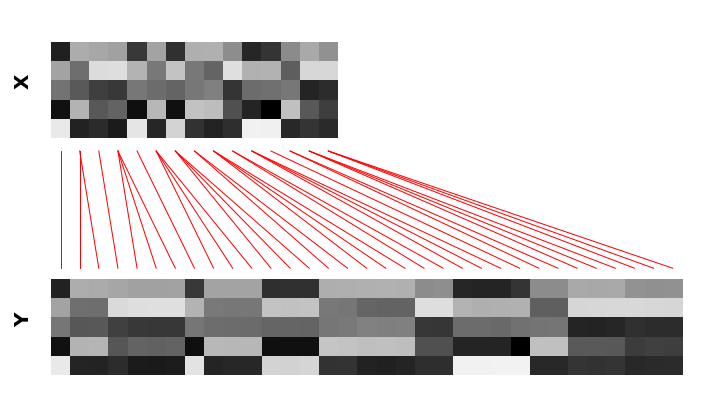

In [9]:
# This is a helper method to generate sample sequences 
# (see helper.py for documentation)

# lenght of the "reference" sequence
lenX = 15

# dimensionality of the feature space
K = 5

# This method generates an example sequence
X, Y, gr_path = generate_example_sequences(
    lenX=lenX, 
    centers=3, 
    n_features=K,
    maxreps=4, 
    minreps=1, 
    noise_scale=0.1
)

# Let us plot the data to see how it looks like!
plot_alignment(X, Y, gr_path)

### Comparing the similarity of the features: Local cost distance

We would like to know how to compare the elements in $\mathbf{X}$ and $\mathbf{Y}$. For this we use a local distance function, which can be any distance(-like) function that is small when $\mathbf{x}_i$ is *similar* to $\mathbf{y}_j$.

Which distance to use depends on the problem at hand, although usual starting points are the Euclidean and the Manhattan ($L_1$) distances.

Using this local distance, we can compare the elements in both sequences by comparing the pairwise distance of all elements in $\mathbf{X}$ and $\mathbf{Y}$. This will result in a matrix $\mathbf{C}$, where the element $\mathbf{C}[i,j]$ is given by

$$\mathbf{C}[i,j] = \text{distance}(\mathbf{x}_i, \mathbf{y}_j)$$

In [29]:
from scipy.spatial.distance import cdist

def pairwise_distance_matrix(
    X: np.ndarray, 
    Y: np.ndarray, 
    metric: str = 'euclidean'
) -> np.ndarray:
    """
    Compute pairwise distance matrix of two sequences
    
    Parameters
    ----------
    X : np.ndarray
        A 2D array with size (n_observations, n_features)
    Y : np.ndarray
        A 2D array with size (m_observations, n_features)
    metric: str
        A string defining a metric (see possibilities 
        in scipy.spatial.distance.cdist)

    Returns
    -------
    C : np.ndarray
        Pairwise cost matrix
    """
    if X.ndim == 1:
        X, Y = np.atleast_2d(X, Y)
        X = X.T
        Y = Y.T
    C = cdist(X, Y, metric=metric)
    return C

Let's visualize the pairwise cost matrix

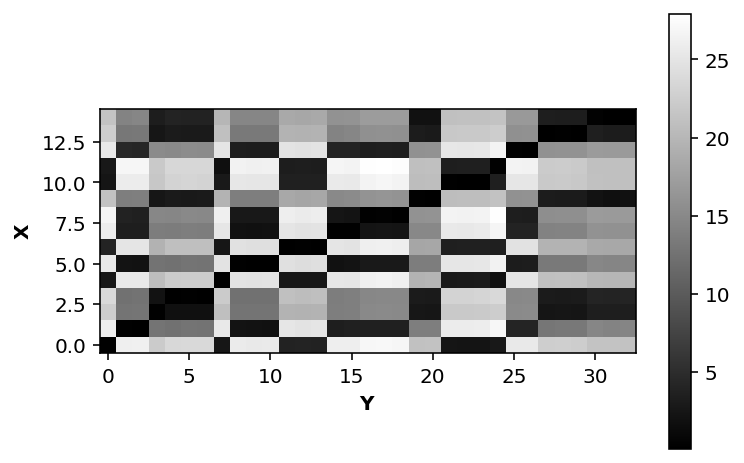

In [30]:
# Visualize cost matrix
C = pairwise_distance_matrix(X, Y)
plt.imshow(C, origin='lower', aspect='equal', cmap='gray')
plt.xlabel(r'$\mathbf{Y}$')
plt.ylabel(r'$\mathbf{X}$')
plt.colorbar()
plt.show()

The DTW Algorithm

* **Input**: Cost matrix $\mathbf{C}$ of size $N \times M$
* **Output**: Optimal warping path $P^*$, $d_{DTW}$

**Procedure**

1. Initialize $N \times M$ matrix $D$ (accumulated cost) by

$$\mathbf{D}[n, 0] = \sum_{k=0}^{n} \mathbf{C}[k, 0]$$

for $n \in [0,N-1]$, and

$$\mathbf{D}[0, m] = \sum_{k=0}^{m} \mathbf{C}[0, k]$$

for $n \in [0, M-1]$

2. Compute in a nested loop for $n=1,\dots, N-1$ and $m=1, \dots, M-1$

$$\mathbf{D}[n, m] = \mathbf{C}[n, m] + \min \left\{\mathbf{D}[n-1, m-1], \mathbf{D}[n-1, m], \mathbf{D}[n, m-1] \right\}$$

3. Get the warping path. Set $l = 0$ and $q_0 = (N-1, M-1)$. Repeat the following steps until $q_l = (0, 0)$
    1. $l \leftarrow l+1$ and $(n, m) = q_{l -1}$
    2. If $n = 0$ then $q_l = (0, m - 1)$,
    3. else if 

4. The dynamic time warping distance is given by

$$d_{DTW}(\mathbf{X}, \mathbf{Y}) = D[N-1, M-1]$$

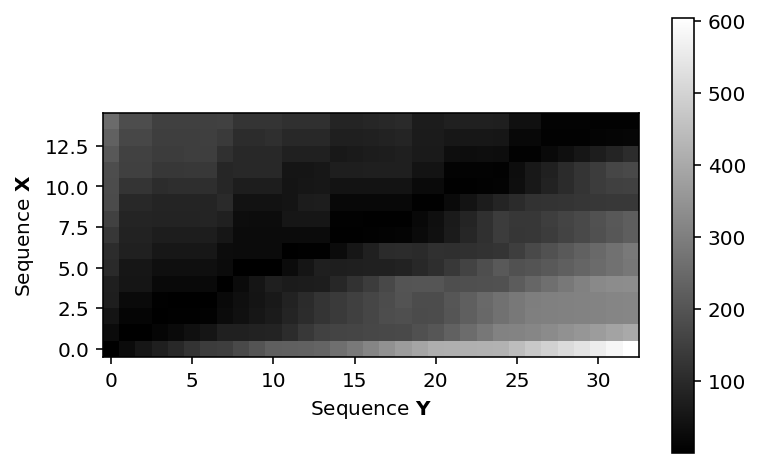

In [12]:
def accumulated_cost_matrix(C: np.ndarray) -> np.ndarray:
    """
    Dynamic time warping cost matrix from a pairwise distance matrix

    Parameters
    ----------
    D : double array
        Pairwise distance matrix (computed e.g., with `cdist`).

    Returns
    -------
    D : np.ndarray
        Accumulated cost matrix
    """
    N = C.shape[0]
    M = C.shape[1]
    D = np.zeros((N, M))
    D[0, 0] = C[0, 0]
    for n in range(1, N):
        D[n, 0] = D[n-1, 0] + C[n, 0]
    for m in range(1, M):
        D[0, m] = D[0, m-1] + C[0, m]
    for n in range(1, N):
        for m in range(1, M):
            D[n, m] = C[n, m] + min(D[n-1, m], D[n, m-1], D[n-1, m-1])
    return D

D = accumulated_cost_matrix(C) 

# Visualize accumulated cost matrix
plt.imshow(D, origin='lower', aspect='equal', cmap='gray')
plt.xlabel(r'Sequence $\mathbf{Y}$')
plt.ylabel(r'Sequence $\mathbf{X}$')
plt.colorbar()
plt.show()

In [13]:
def optimal_warping_path(D):
    """
    Compute the warping path given an accumulated cost matrix

    Parameters
    ----------
    D: np.ndarray
        Accumulated cost Matrix
    
    Returns
    -------
    P: np.ndarray
        Optimal warping path
    """
    N = D.shape[0]
    M = D.shape[1]
    n = N - 1
    m = M - 1
    P = [(n, m)]
    while n > 0 or m > 0:
        if n == 0:
            cell = (0, m - 1)
        elif m == 0:
            cell = (n - 1, 0)
        else:
            val = min(D[n-1, m-1], D[n-1, m], D[n, m-1])
            if val == D[n-1, m-1]:
                cell = (n-1, m-1)
            elif val == D[n-1, m]:
                cell = (n-1, m)
            else:
                cell = (n, m-1)
        P.append(cell)
        (n, m) = cell
    P.reverse()
    return np.array(P)
        
P = optimal_warping_path(D)


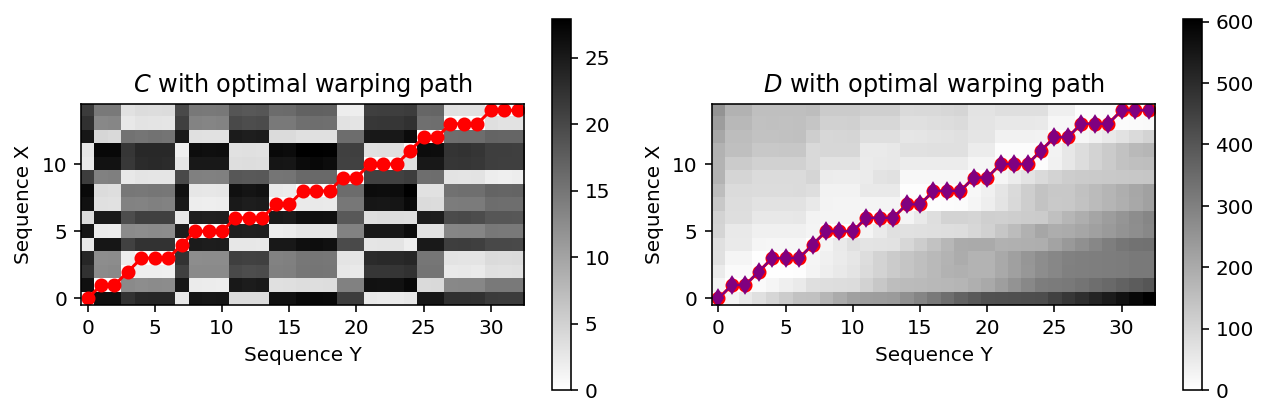

In [31]:
plt.figure(figsize=(9, 3))
plt.subplot(1, 2, 1)
plt.imshow(C, cmap='gray_r', origin='lower', aspect='equal')
plt.plot(P[:, 1], P[:, 0], marker='o', color='r')
plt.clim([0, np.max(C)])
plt.colorbar()
plt.title('$C$ with optimal warping path')
plt.xlabel('Sequence Y')
plt.ylabel('Sequence X')

plt.subplot(1, 2, 2)
plt.imshow(D, cmap='gray_r', origin='lower', aspect='equal')
plt.plot(P[:, 1], P[:, 0], marker='o', color='r')
plt.plot(gr_path[:, 1], gr_path[:, 0], marker='d', color='purple', linewidth=1.1)
plt.clim([0, np.max(D)])
plt.colorbar()
plt.title('$D$ with optimal warping path')
plt.xlabel('Sequence Y')
plt.ylabel('Sequence X')

plt.tight_layout()


Let's put everything together into a single function

In [32]:
def naive_dynamic_time_warping(
    X: np.ndarray, 
    Y: np.ndarray, 
    metric: str ='euclidean'
) -> (np.ndarray, float):
    """
    Naive Implementation of Vanilla Dynamic Time Warping
    
    Parameters
    ----------
    X : np.ndarray
        Array X
    Y: np.ndarray
        Array Y
    metric: string
        Scipy Metric
        
    Returns
    -------
    warping_path: np.ndarray
        The warping path for the optimal alignment.
    dtwd : float
        The dynamic time warping distance of the alignment.
    """
    # Compute pairwise distance matrix
    C = pairwise_distance_matrix(X, Y, metric=metric)
    # Compute accumulated cost matrix
    D = accumulated_cost_matrix(C)
    dtwd = D[-1, -1]
    # Get warping path
    warping_path = optimal_warping_path(D)
    return warping_path, dtwd

This naive implementation is very slow! You can only use it for aligning small sequences. For practical stuff, we are going to use the `fasdtw` package. This package contains an efficient implementation of vanilla DTW, as well as a faster approximation, called FastDTW.

In [16]:
from fastdtw import dtw, fastdtw
from scipy.spatial import distance as sp_dist

def dynamic_time_warping(
    X: np.ndarray, 
    Y: np.ndarray, 
    metric: str = "euclidean",
) -> (np.ndarray, float):
    """
    Vanilla Dynamic Time Warping
    
    This is a more efficient implementation
    
    Parameters
    ----------
    X : np.ndarray
    Y: np.ndarray
    metric : str
       The name of the metric to use
    
    Returns
    -------
    warping_path: np.ndarray
        The warping path for the best alignment
    dtwd : float
        The dynamic time warping distance of the alignment.
    """
    # Get distance measure from scipy dist
    dist = getattr(sp_dist, metric)
    dtwd, warping_path = dtw(X, Y, dist=dist)
    
    # Make warping path a numpy array
    warping_path = np.array(warping_path)
    return warping_path, dtwd

def fast_dynamic_time_warping(
    X: np.ndarray, 
    Y: np.ndarray, 
    metric: str = "euclidean",
) -> (np.ndarray, float):
    """
     Fast Dynamic Time Warping
    
    This is an approximate solution to dynamic time warping.
    
    Parameters
    ----------
    X : np.ndarray
    Y: np.ndarray
    metric : str
       The name of the metric to use
    
    Returns
    -------
    warping_path: np.ndarray
        The warping path for the best alignment
    dtwd : float
        The dynamic time warping distance of the alignment.
    """
    
    # Get distance measure from scipy dist
    dist = getattr(sp_dist, metric)
    dtwd, warping_path = fastdtw(X, Y, dist=dist)
    
    # Make path a numpy array
    warping_path = np.array(warping_path)
    return warping_path, dtwd

# The output of the dtw 
path_naive, dtwd_naive = naive_dynamic_time_warping(X, Y)
path_optimized, dtwd_optimized = dynamic_time_warping(X, Y)
path_fdtw, dtwd_fdtw = fast_dynamic_time_warping(X, Y)

### Creating note-level alignments from sequential alignment information

Dynamic Time Warping and related sequence alignment algorithms return a path between two sequences or time series. Note alignment of two polyphonic parts is categorically different from a time series alignment. To get to a note alignment, we need to figure out what notes are played at a specific time in the piano roll. Sometimes this information might be imprecise so we need to relax the search for notes at some piano roll time to find all relevant notes.

In [17]:
score_pr, sidx = pt.utils.music.compute_pianoroll(
    note_info=score,
    time_unit="beat",
    time_div=8,
    return_idxs=True,
    piano_range=False,
)

performance_pr, pidx = pt.utils.music.compute_pianoroll(
    note_info=performance,
    time_unit="sec",
    time_div=10,
    return_idxs=True,
    piano_range=False
)

In [18]:
# pitch, onset, offset
sidx

array([[ 48,   0,   8,  48],
       [ 74,   0,   2,  74],
       [ 72,   2,   4,  72],
       [ 71,   4,   6,  71],
       [ 72,   6,   8,  72],
       [ 60,   8,  16,  60],
       [ 71,   8,  10,  71],
       [ 72,  10,  12,  72],
       [ 71,  12,  14,  71],
       [ 72,  14,  16,  72],
       [ 64,  16,  24,  64],
       [ 81,  16,  18,  81],
       [ 79,  18,  20,  79],
       [ 78,  20,  22,  78],
       [ 79,  22,  24,  79],
       [ 60,  24,  32,  60],
       [ 78,  24,  26,  78],
       [ 79,  26,  28,  79],
       [ 78,  28,  30,  78],
       [ 79,  30,  32,  79],
       [ 65,  32,  40,  65],
       [ 80,  32,  34,  80],
       [ 81,  34,  36,  81],
       [ 84,  36,  38,  84],
       [ 83,  38,  40,  83],
       [ 60,  40,  48,  60],
       [ 86,  40,  42,  86],
       [ 84,  42,  44,  84],
       [ 83,  44,  46,  83],
       [ 81,  46,  48,  81],
       [ 60,  48,  56,  60],
       [ 64,  48,  56,  64],
       [ 81,  48,  50,  81],
       [ 79,  50,  52,  79],
       [ 88,  

In [19]:
# idx correspond to notes in note_array
score.note_array()

array([( 0.  , 1.  ,  0.  , 1.  ,   0, 4, 48, 5, 'n9', 4),
       ( 0.  , 0.25,  0.  , 0.25,   0, 1, 74, 1, 'n1', 4),
       ( 0.25, 0.25,  0.25, 0.25,   1, 1, 72, 1, 'n2', 4),
       ( 0.5 , 0.25,  0.5 , 0.25,   2, 1, 71, 1, 'n3', 4),
       ( 0.75, 0.25,  0.75, 0.25,   3, 1, 72, 1, 'n4', 4),
       ( 1.  , 1.  ,  1.  , 1.  ,   4, 4, 60, 5, 'n10', 4),
       ( 1.  , 0.25,  1.  , 0.25,   4, 1, 71, 1, 'n5', 4),
       ( 1.25, 0.25,  1.25, 0.25,   5, 1, 72, 1, 'n6', 4),
       ( 1.5 , 0.25,  1.5 , 0.25,   6, 1, 71, 1, 'n7', 4),
       ( 1.75, 0.25,  1.75, 0.25,   7, 1, 72, 1, 'n8', 4),
       ( 2.  , 1.  ,  2.  , 1.  ,   8, 4, 64, 5, 'n19', 4),
       ( 2.  , 0.25,  2.  , 0.25,   8, 1, 81, 1, 'n11', 4),
       ( 2.25, 0.25,  2.25, 0.25,   9, 1, 79, 1, 'n12', 4),
       ( 2.5 , 0.25,  2.5 , 0.25,  10, 1, 78, 1, 'n13', 4),
       ( 2.75, 0.25,  2.75, 0.25,  11, 1, 79, 1, 'n14', 4),
       ( 3.  , 1.  ,  3.  , 1.  ,  12, 4, 60, 5, 'n20', 4),
       ( 3.  , 0.25,  3.  , 0.25,  12, 1, 78, 1, 

In [20]:
# invent a linear alignment for testing
from helper import dummy_linear_alignment

linear_alignment = dummy_linear_alignment(score_pr.todense().T, performance_pr.todense().T)

In [21]:
performance_pr.shape

(128, 232)

In [22]:
linear_alignment

array([[  0,   0],
       [  1,   0],
       [  2,   1],
       [  3,   1],
       [  4,   2],
       [  5,   3],
       [  6,   3],
       [  7,   4],
       [  8,   4],
       [  9,   5],
       [ 10,   6],
       [ 11,   6],
       [ 12,   7],
       [ 13,   7],
       [ 14,   8],
       [ 15,   9],
       [ 16,   9],
       [ 17,  10],
       [ 18,  10],
       [ 19,  11],
       [ 20,  12],
       [ 21,  12],
       [ 22,  13],
       [ 23,  13],
       [ 24,  14],
       [ 25,  15],
       [ 26,  15],
       [ 27,  16],
       [ 28,  16],
       [ 29,  17],
       [ 30,  18],
       [ 31,  18],
       [ 32,  19],
       [ 33,  19],
       [ 34,  20],
       [ 35,  21],
       [ 36,  21],
       [ 37,  22],
       [ 38,  22],
       [ 39,  23],
       [ 40,  24],
       [ 41,  24],
       [ 42,  25],
       [ 43,  25],
       [ 44,  26],
       [ 45,  27],
       [ 46,  27],
       [ 47,  28],
       [ 48,  29],
       [ 49,  29],
       [ 50,  30],
       [ 51,  30],
       [ 52,

In [23]:
dtw_alignment, _ = fast_dynamic_time_warping(X=score_pr.todense().T, Y=performance_pr.todense().T, metric="canberra")

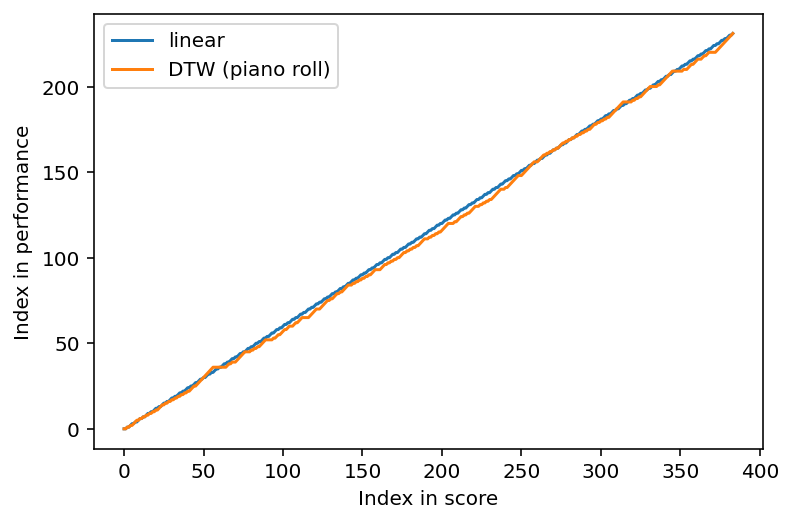

In [24]:
plt.plot(linear_alignment[:, 0], linear_alignment[:, 1], label="linear")
plt.plot(dtw_alignment[:, 0], dtw_alignment[:, 1], label="DTW (piano roll)")
plt.legend()
plt.xlabel('Index in score')
plt.ylabel('Index in performance')
plt.show()

In [25]:
from helper import greedy_note_alignment


In [26]:
note_alignment = greedy_note_alignment(dtw_alignment, sidx, score.note_array(), pidx, performance.note_array())

ValueError: too many values to unpack (expected 3)

## Comparing alignments

In [ ]:
gt_alignment_fn = "./data/mozart_k265_var1.match"

al_perf, gt_alignment = pt.load_match(gt_alignment_fn)

In [ ]:
note_alignment[:10]

To inspect an alignment, we can use [**Parangonada**](https://sildater.github.io/parangonada/), a tool to compare alignments developed at our institute!

In [ ]:
from helper import evaluate_alignment_notewise

precision, recall, fscore = evaluate_alignment_notewise(
    prediction=note_alignment,
    ground_truth=gt_alignment
)

print(precision, recall, fscore)

In [ ]:
# Export files to Parangonada
outdir = "parangonada_files"
if not os.path.exists(outdir):
    os.mkdir(outdir)
pt.save_parangonada_csv(
    alignment=note_alignment,
    performance_data=performance,
    score_data=score,
    outdir="parangonada_files",
)

## Conclusions

In this notebook we explored symbolic alignment with DTW. 

## References

#### Alignment Basics

* M. Müller.

* A. Arzt.

#### DTW

#### HMMs

#### Lyrics to audio alignment

* N. Lizé-Masclef, A. Vaglio, M. Moussallam. “User-centered evaluation of lyrics to audio alignment”, International Society for Music Information Retrieval (ISMIR) conference, 2021.

* M. Mauch, F: Hiromasa, M. Goto. “Lyrics-to-audio alignment and phrase-level segmentation using incomplete internet-style chord annotations”, Frontiers in Proceedings of the Sound Music Computing Conference (SMC), 2010.

* G. Dzhambazov. “Knowledge-Based Probabilistic Modeling For Tracking Lyrics In Music Audio Signals”, PhD Thesis, 2017.

* H. Fujihara, M. Goto, J. Ogata, H. Okuno. “LyricSynchronizer: Automatic synchronization system between musical audio signals and lyrics”, IEEE Journal of Selected Topics in Signal Processing, VOL. 5, NO. 6, 2011